In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mcmctoolbox.functoolbox import flat

import os
import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

import stan

import nest_asyncio
nest_asyncio.apply()

np.random.seed(1234)

In [2]:
# Load DataBase Locally
pdb_path = os.path.join("../../posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-AnnulusGaussianMixture-test-AnnulusGaussianMixture")
stan_file_path = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan_file_path, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

In [3]:
stan_sampler = stan.build(posterior.model.stan_code(), data=posterior.data.values(), random_seed=1234)

fit_single_chain = stan_sampler.sample(num_chains=1, num_samples=100_001)
df_single_chain = fit_single_chain.to_frame()
df_single_chain[['x.1','x.2']].to_csv('Data/AnnulusGaussianMixture_NUTS_1c.csv', index=False, header=False)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_dblz6hn1/model_kgffut57.stan', line 5, column 4: A
    control flow statement inside function norm depends on argument x. At
    '/tmp/httpstan_dblz6hn1/model_kgffut57.stan', line 32, column 30 to
    column 31, the value of x depends on parameter(s): x.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (101001/101001)
Sampling: 100% (101001/101001), done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!


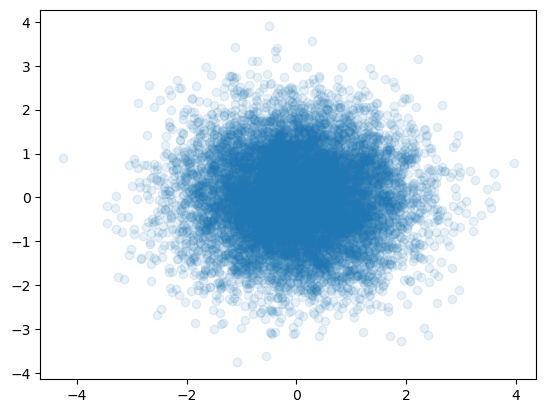

In [4]:
plt.plot(df_single_chain['x.1'][::10], df_single_chain['x.2'][::10], 'o', alpha=0.1)
plt.savefig('Pic/AnnulusGaussianMixture_NUTS_1c.png', dpi=300)

In [5]:
fit_4_chain = stan_sampler.sample(num_chains=4, num_samples=int(100_000/4 + 1))
df_4_chain = fit_4_chain.to_frame()
df_4_chain[['x.1','x.2']].to_csv('Data/AnnulusGaussianMixture_NUTS_4c.csv', index=False, header=False)
fit_4_chain1 = np.vstack((fit_4_chain._draws[-2, :, 0], fit_4_chain._draws[-1, :, 0]))
fit_4_chain2 = np.vstack((fit_4_chain._draws[-2, :, 1], fit_4_chain._draws[-1, :, 1]))
fit_4_chain3 = np.vstack((fit_4_chain._draws[-2, :, 2], fit_4_chain._draws[-1, :, 2]))
fit_4_chain4 = np.vstack((fit_4_chain._draws[-2, :, 3], fit_4_chain._draws[-1, :, 3]))

Sampling:   0%
Sampling:  25% (26001/104004)
Sampling:  50% (52002/104004)
Sampling:  75% (78003/104004)
Sampling: 100% (104004/104004)
Sampling: 100% (104004/104004), done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!


In [6]:
fit_4_chain1 = np.vstack((fit_4_chain._draws[-2, :, 0], fit_4_chain._draws[-1, :, 0]))
fit_4_chain2 = np.vstack((fit_4_chain._draws[-2, :, 1], fit_4_chain._draws[-1, :, 1]))
fit_4_chain3 = np.vstack((fit_4_chain._draws[-2, :, 2], fit_4_chain._draws[-1, :, 2]))
fit_4_chain4 = np.vstack((fit_4_chain._draws[-2, :, 3], fit_4_chain._draws[-1, :, 3]))

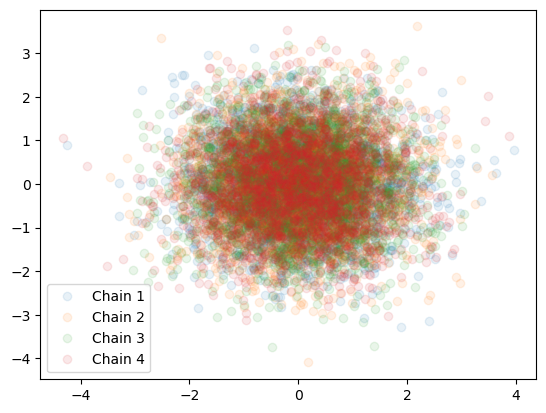

In [7]:
plt.plot(fit_4_chain1[0,::10], fit_4_chain1[1,::10], 'o', alpha=0.1, label="Chain 1")
plt.plot(fit_4_chain2[0,::10], fit_4_chain2[1,::10], 'o', alpha=0.1, label="Chain 2")
plt.plot(fit_4_chain3[0,::10], fit_4_chain3[1,::10], 'o', alpha=0.1, label="Chain 3")
plt.plot(fit_4_chain4[0,::10], fit_4_chain4[1,::10], 'o', alpha=0.1, label="Chain 4")
plt.legend()

plt.savefig('Pic/AnnulusGaussianMixture_NUTS_4c.png', dpi=300)